# Loading Data from Preprocessing


In [ ]:
from preprocessing.preprocessing import load_data, preprocess_data


ModuleNotFoundError: No module named 'sklearn'

In [ ]:
df, art_info, molecules = load_data()
df = preprocess_data(df, art_info, molecules)


In [46]:
import os
import sys
import polars as pl

path = "../data/ordcustprod.csv"
lazy_df = pl.scan_csv(
    #"ordcustprod.csv",
    path, # 1M rows
    n_rows=50000,
    has_header=True,
    infer_schema_length=5000, 
    low_memory=True,
    try_parse_dates=True,
    encoding="utf8",        
    rechunk=False   ,
    truncate_ragged_lines=True,
    ignore_errors=True)

lazy_df = lazy_df.sort("cust_no", "transaction_dte")
df = lazy_df.collect()

print(df.shape)


(50000, 2062)


In [47]:
columns = df.columns
selected_columns = columns[:197]
selected_columns
# only selected columns
df = df.select(selected_columns)
columns_to_remove = [f'fault_cat_{i}' for i in range(1, 18)] + \
                    [f'fault_dte_{i}' for i in range(1, 18)] + \
                    [f'fault_descr_{i}' for i in range(1, 18)] + \
                    [f'fault_src_{i}' for i in range(1, 18)] + \
                    [f'fault_corrt_{i}' for i in range(1, 18)]
              
df = df.drop(columns_to_remove)
# remove + 'iqvia_stop', 'pipeline_actual', 'pipeline_history', 'pipeline_start'
df =df.drop(['iqvia_stop', 'pipeline_actual', 'pipeline_history', 'pipeline_start', 'pipeline_end', 'Actual DOT/Unit','inv_dte',
 'Standard DOT/Unit','Actual DOT','Standard DOT',])
df.shape


(50000, 102)

In [44]:
df.columns 

['orig_ord_type_cde',
 'presc_no',
 'orig_ord_line_id',
 'galfrm_day',
 'Pharmacode',
 'Product ID MES',
 'Product Description',
 'Product Availability',
 'Product Dispension Type',
 'Product Dispension Type Class',
 'Product CatCode 1',
 'Product CatCode 2',
 'Product Generics Code',
 'Product Basename',
 'Product Company',
 'Product ATC (EPHMRA)',
 'Product DOT/Unit PCG',
 'Product Class PCG',
 'Product Type',
 'Product Segment',
 'Main Supplier',
 'pipeline_end',
 'official Pharmacode',
 'Product ATC (WHO)',
 'ATC (WHO) level 1',
 'ATC (WHO) level 2',
 'ATC (WHO) level 3',
 'ATC (WHO) level 4',
 'ATC (WHO) level 5',
 'Product Category Management',
 'Category Management level 1',
 'Category Management level 2',
 'Category Management level 3',
 'Category Management level 4',
 'Category Management level 5',
 'Product Therapeutic Index Code',
 'Product Unit Count',
 'Product Unit',
 'Product Unit Container',
 'Product Launch Date',
 'pharm_no',
 'nk_flg',
 'nk_year',
 'ord_no_new',
 'tr

## Cleaning data 


In [4]:
import polars as pl
from datetime import timedelta

# Helper functions
def load_and_preprocess_art_info(file_path):
    """Load and preprocess ART_INFO data."""
    art_info = pl.read_csv(file_path)
    art_info = art_info.with_columns(pl.col("PHARMACODE").cast(pl.Int64).alias("official Pharmacode"))
    return art_info.select(["ART_ANR", "ART_BASENAME", "ART_FULLNAME", "ART_FORM", "CONCT", "ART_MULTIPL", "official Pharmacode"])


def load_and_preprocess_molecules(file_path):
    """Load and preprocess molecules data."""
    molecules = pl.read_csv(file_path, has_header=True)
    return molecules.select(["ART_ANR", "MolText", "MONO COMBI"])


def calculate_refill_metrics(df):
    """Calculate refill metrics and adherence scores."""
    df = df.with_columns((pl.col("transaction_dte") - pl.col('Days Since Last Order')).dt.total_days().alias("days_since_prev"))
    df = df.with_columns([
        # Refill ratio and flags
        pl.when(pl.col("prev_median_DOT").is_not_null())
        .then((pl.col("days_since_prev") / pl.col("prev_median_DOT")))
        .otherwise(None)
        .alias("refill_ratio"),
        pl.when(pl.col("refill_ratio") < 0.9).then(1).otherwise(0).alias("early_refill_flag"),
        pl.when(pl.col("refill_ratio") > 1.1).then(1).otherwise(0).alias("late_refill_flag"),
        pl.when(pl.col("refill_ratio").is_not_null())
        .then(1 / (1 + abs(pl.col("refill_ratio") - 1)))
        .otherwise(None)
        .alias("adherence_score")])
    return df


def summarize_adherence(df):
    """Summarize adherence metrics by customer."""
    return df.group_by("cust_no").agg([
        pl.col("adherence_score").mean().alias("mean_adherence_score"),
        pl.col("early_refill_flag").sum().alias("total_early_refills"),
        pl.col("late_refill_flag").sum().alias("total_late_refills"),
        pl.col("refill_ratio").median().alias("median_refill_ratio"),
        pl.col("refill_ratio").std().alias("std_dev_refill_ratio")])


def calculate_affinity(df):
    """Calculate product affinity and diversity."""
    product_counts = (
        df.select(["cust_no", "product_atc", "pharm_no"])
        .unique(subset=["cust_no", "product_atc", "pharm_no"])
        .group_by("cust_no")
        .agg(pl.count("product_atc").alias("total_products"))
    )
    product_affinity = df.group_by("cust_no").agg([
        pl.col("product_atc").n_unique().alias("unique_therapeutic_classes"),
        pl.col("product_atc").count().alias("total_products_bought"),
    ]).with_columns(
        (1 - (1 / pl.col("unique_therapeutic_classes"))).alias("product_affinity_score")
    )
    return product_counts, product_affinity


def calculate_refill_trends(df):
    """Calculate refill trends based on recent and overall mean refill gaps."""
    most_recent_date = df.select(pl.col("transaction_dte").max())[0, 0]
    last_8_months_df = df.filter(pl.col("transaction_dte") >= (most_recent_date - timedelta(days=240)))

    mean_refill_gap = df.group_by(["cust_no", "pharm_no", "product_atc"]).agg(
        pl.col("days_since_prev").mean().alias("mean_refill_gap_overall")
    )
    mean_refill_gap_recent = last_8_months_df.group_by(["cust_no", "pharm_no", "product_atc"]).agg(
        pl.col("days_since_prev").mean().alias("mean_refill_gap_recent")
    )

    df = df.join(mean_refill_gap, on=["cust_no", "pharm_no", "product_atc"], how="left")
    df = df.join(mean_refill_gap_recent, on=["cust_no", "pharm_no", "product_atc"], how="left")

    df = df.with_columns(
        pl.when(pl.col("mean_refill_gap_recent") < pl.col("mean_refill_gap_overall"))
        .then(1)
        .when(pl.col("mean_refill_gap_recent") > pl.col("mean_refill_gap_overall"))
        .then(-1)
        .otherwise(0)
        .alias("refill_trend")
    )
    return df


def extract_customer_features(df):
    """Extract customer-level features."""
    return df.group_by("cust_no").agg([
        pl.col("transaction_dte").max().alias("last_order_date"),
        pl.col("transaction_dte").min().alias("first_order_date"),
        pl.col("product_atc").n_unique().alias("unique_products"),
        pl.col("product_atc").mode().alias("most_purchased_product"), #  the most occurring value(s).
        pl.col("Mixed DOT").mean().alias("avg_mixed_dot"),
        pl.col("Mixed DOT").std().alias("std_mixed_dot"),
        pl.col("days_since_prev").mean().alias("avg_days_between_orders"),
        pl.col("mean_adherence_score").mean().alias("overall_adherence_score"),
        pl.col("unique_therapeutic_classes").first(),
        pl.col("total_products_bought").first(),
        pl.col("product_affinity_score").first()])


# Main Workflow
art_info = load_and_preprocess_art_info("../data/ART_INFO.csv")
molecules = load_and_preprocess_molecules("../data/molecules.csv")

df2 = (
    df.with_columns(pl.col("official Pharmacode").cast(pl.Int64))
    .join(art_info, on="official Pharmacode", how="inner")
    .join(molecules, on="ART_ANR", how="left")
    .filter(pl.col("Product ATC (WHO)").is_not_null() & pl.col("Product ATC (EPHMRA)").is_not_null())
    .sort("cust_no", "transaction_dte")
    .with_columns(pl.col("Product DOT/Unit PCG").fill_null(1.0))
    .with_columns(
        pl.when(pl.col("Product ATC (WHO)").is_not_null())
        .then(pl.col("Product ATC (EPHMRA)").str.slice(0, 6))
        .otherwise(pl.col("Product ATC (EPHMRA)").str.slice(0, 6))
        .alias("product_atc")))

# Feature Engineering
df2 = calculate_refill_metrics(df2)
adherence_summary = summarize_adherence(df2)
product_counts, product_affinity = calculate_affinity(df2)

df2 = df2.join(adherence_summary, on="cust_no", how="inner")
df2 = df2.join(product_counts, on="cust_no", how="inner")
df2 = df2.join(product_affinity, on="cust_no", how="inner")

df2 = calculate_refill_trends(df2)
customer_features = extract_customer_features(df2)

# Final Aggregation
df2 = df2.join(customer_features, on="cust_no", how="inner")


InvalidOperationError: - not allowed on date and i64

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'with_columns' <---
DF ["orig_ord_type_cde", "presc_no", "orig_ord_line_id", "galfrm_day"]; PROJECT */2071 COLUMNS; SELECTION: None

In [12]:
art_info = pl.read_csv("../data/ART_INFO.csv")
art_info = art_info.with_columns(pl.col("PHARMACODE").cast(pl.Int64)).rename({"PHARMACODE": "official Pharmacode"})
art_info_filtered = art_info.select(["ART_ANR", "ART_BASENAME", "ART_FULLNAME", "ART_FORM", "CONCT", "ART_MULTIPL",  "official Pharmacode"])
df2 = df.with_columns(pl.col("official Pharmacode").cast(pl.Int64))
df2 = df2.join(art_info_filtered, on="official Pharmacode", how="inner")

molecules = pl.read_csv("../data/molecules.csv", has_header=True)
molecules_filtered = molecules.select(["ART_ANR", "MolText","MONO COMBI"]) 
df2 = df2.join(molecules_filtered, on="ART_ANR", how="left")

df2 = df2.filter(pl.col("Product ATC (WHO)").is_not_null() & pl.col("Product ATC (EPHMRA)").is_not_null())


df2 = df2.sort("cust_no", "transaction_dte")
df2 = df2.with_columns([pl.col("Product DOT/Unit PCG").fill_null(1.0)])

df2 = df2.with_columns(pl.when(pl.col("Product ATC (WHO)").is_not_null()).then(pl.col("Product ATC (EPHMRA)").str.slice(0, 6)).otherwise(pl.col("Product ATC (EPHMRA)").str.slice(0, 6)).alias("product_atc"))

# Add transaction details and calculate features
df2 = df2.with_columns([
    pl.col("pharm_no").shift(1).over("cust_no").alias("prev_pharm_no"),
    pl.col("product_atc").shift(1).over("cust_no").alias("prev_product_atc"),
    pl.col("transaction_dte").shift(1).over("cust_no").alias("prev_transaction_dte"),
    pl.col("Mixed DOT").mean().over("cust_no").alias("mixed_mean_DOT")])

# Calculate the difference in days between transactions
df2 = df2.with_columns((pl.col("transaction_dte") - pl.col("prev_transaction_dte")).dt.total_days().alias("days_since_prev"))

# Affinity components
df2 = df2.with_columns([
    # Time Factor
    (pl.col("days_since_prev") / pl.col("mixed_mean_DOT")).fill_null(0).alias("time_factor"),
    # ATC Similarity Factor
    pl.when(pl.col("product_atc") != pl.col("prev_product_atc"))
    .then(1)
    .otherwise(0)
    .alias("atc_similarity_factor"),
    # Product Change Factor
    pl.when(pl.col("pharm_no") != pl.col("prev_pharm_no"))
    .then(1)
    .otherwise(0)
    .alias("product_change_factor")])
# calculate affinity
df2 = df2.with_columns((pl.col("time_factor") + pl.col("atc_similarity_factor") + pl.col("product_change_factor")).alias("product_switch_affinity"))
print(len(df2))
print(df2.shape)

# Product affinity and diversity
unique_products_per_customer = df2.select(["cust_no", "product_atc", "pharm_no"]).unique(subset=["cust_no", "product_atc", "pharm_no"])
product_counts = unique_products_per_customer.group_by("cust_no").agg(pl.count("product_atc").alias("total_products"))

df2 = df2.join(product_counts, on="cust_no", how="inner")
print(len(df2))
print(df2.shape)
product_affinity = df2.group_by("cust_no").agg(pl.col("product_atc").n_unique().alias("unique_therapeutic_classes"),pl.col("product_atc").count().alias("total_products_bought")).with_columns(
    (1 - (1 / pl.col("unique_therapeutic_classes"))).alias("product_affinity_score")
)
df2 = df2.join(product_affinity, on="cust_no", how="inner")
print(len(df2))
print(df2.shape)

# Calculate median DOT for each product (pharm_no + product_atc) # Median DOT per product
product_dot_stats = df2.group_by(["pharm_no", "product_atc"]).agg(
    pl.col("Mixed DOT").median().alias("median_DOT_per_product"),
    pl.col("Mixed DOT").mean().alias("mean_DOT_per_product"))

# Join back to the main DataFrame
df2 = df2.join(product_dot_stats, on=["pharm_no", "product_atc"], how="inner")
print(len(df2))
print(df2.shape)
# Add previous transaction details
df2 = df2.with_columns([pl.col("median_DOT_per_product").shift(1).over("cust_no").alias("prev_median_DOT")])

# Calculate refill adherence
df2 = df2.with_columns(
    pl.when(pl.col("prev_median_DOT").is_not_null())
    .then((pl.col("days_since_prev") / pl.col("prev_median_DOT")).alias("refill_ratio"))
    .otherwise(None)
)
df2 = df2.with_columns([
    pl.when(pl.col("refill_ratio") < 0.9).then(1).otherwise(0).alias("early_refill_flag"), # # Flag early refills (overlap)
    pl.when(pl.col("refill_ratio") > 1.1).then(1).otherwise(0).alias("late_refill_flag"),# Flag late refills (gap)
    # Adherence score (1 = perfect adherence, decrease for early/late refills)
    pl.when(pl.col("refill_ratio").is_not_null())
    .then(1 / (1 + abs(pl.col("refill_ratio") - 1)))
    .otherwise(None).alias("adherence_score")
])

adherence_summary = df2.group_by("cust_no").agg([
    pl.col("adherence_score").mean().alias("mean_adherence_score"),
    pl.col("early_refill_flag").sum().alias("total_early_refills"),
    pl.col("late_refill_flag").sum().alias("total_late_refills"),
    pl.col("refill_ratio").median().alias("median_refill_ratio"),
    pl.col("refill_ratio").std().alias("std_dev_refill_ratio"),
])
print(len(df2))
print(df2.shape)
df2 = df2.join(adherence_summary, on="cust_no", how="inner")
print(len(df2))
print(df2.shape)

from datetime import timedelta

# Step 1: Calculate mean refill gaps per customer and product
mean_refill_gap = df2.group_by(["cust_no", "pharm_no", "product_atc"]).agg(pl.col("days_since_prev").mean().alias("mean_refill_gap_overall"))

# Step 2: Focus on transactions in the last 8 months
most_recent_date =  df2.select(pl.col("transaction_dte").max())[0, 0]

# Filter for last 8 months
last_8_months_df = df2.filter(pl.col("transaction_dte") >= (most_recent_date - timedelta(days=240)))

# Calculate mean refill gap for last 8 months
mean_refill_gap_recent = last_8_months_df.group_by(["cust_no", "pharm_no", "product_atc"]).agg(pl.col("days_since_prev").mean().alias("mean_refill_gap_recent"))



print(df2.shape)
# Step 3: Join recent and overall metrics
df2 = df2.join(mean_refill_gap, on=["cust_no", "pharm_no", "product_atc"], how="left")
df2 = df2.join(mean_refill_gap_recent, on=["cust_no", "pharm_no", "product_atc"], how="left")
print(len(df2))
print(df2.shape)
# Step 4: Compare recent vs. overall mean refill gaps
df2 = df2.with_columns(
    pl.when(pl.col("mean_refill_gap_recent") < pl.col("mean_refill_gap_overall"))
    .then(1)  # Improving
    .when(pl.col("mean_refill_gap_recent") > pl.col("mean_refill_gap_overall"))
    .then(-1)  # Declining
    .otherwise(0)  # Stable
    .alias("refill_trend"))
# Step 5: Calculate adherence score (composite metric)
df2 = df2.with_columns(
    (pl.col("mean_adherence_score") * (1 / (1 + abs(pl.col("mean_refill_gap_recent") - pl.col("mean_refill_gap_overall"))))).alias("composite_adherence_score"))

# Step 6: Summarize by customer
customer_summary = df2.group_by("cust_no").agg([
    pl.col("composite_adherence_score").mean().alias("mean_composite_adherence_score"),
    pl.col("refill_trend").value_counts().alias("refill_trend_summary")
])

# Step 7: Join back to the main DataFrame
df2 = df2.join(customer_summary, on="cust_no", how="inner")


print(len(df2))
print(df2.shape)
# Step 1: Explode refill trend summary
exploded = df2.explode("refill_trend_summary").filter(pl.col("refill_trend_summary").is_not_null())


# Step 2: Extract fields from struct
exploded = exploded.with_columns([
    pl.col("refill_trend_summary").struct.field("refill_trend").alias("trend_category"),
    pl.col("refill_trend_summary").struct.field("count").alias("trend_counts")
]).drop("refill_trend_summary")

# Step 3: Filter and aggregate counts by trend
trend_counts = exploded.group_by(["cust_no", "trend_category"]).agg(
    pl.col("trend_counts").sum().alias("total_counts")
)

# Step 4: Map trend_category to descriptive labels
trend_counts = trend_counts.with_columns(
    pl.when(pl.col("trend_category") == 1).then(pl.lit("Improving"))
    .when(pl.col("trend_category") == 0).then(pl.lit("Stable"))
    .when(pl.col("trend_category") == -1).then(pl.lit("Declining"))
    .otherwise(pl.lit("Unknown"))
    .alias("trend_category_label")
)

trend_counts_pivot = trend_counts.pivot(
    values="total_counts",  # Values to pivot
    index=["cust_no"],      # Group by customer
    columns=["trend_category_label"],  # Pivot on the label
    aggregate_function=None  # No aggregation needed
)
trend_counts_pivot = trend_counts_pivot.fill_null(0)
# Ensure missing columns are added to the pivoted DataFrame
for col in ["Improving", "Stable", "Declining"]:
    if col not in trend_counts_pivot.columns:
        trend_counts_pivot = trend_counts_pivot.with_column(pl.lit(0).alias(col))
# Join pivoted data back to df2
df2 = df2.join(trend_counts_pivot, on="cust_no", how="inner")
df2 = df2.fill_null(0)
df2 = df2.drop("refill_trend_summary")

df2.head(2)
df2 = df2.with_columns([
    # Proportions
    (pl.col("Improving") / (pl.col("Improving") + pl.col("Stable") + pl.col("Declining"))).fill_null(0).alias("proportion_improving"),
    (pl.col("Stable") / (pl.col("Improving") + pl.col("Stable") + pl.col("Declining"))).fill_null(0).alias("proportion_stable"),
    (pl.col("Declining") / (pl.col("Improving") + pl.col("Stable") + pl.col("Declining"))).fill_null(0).alias("proportion_declining")])
df2 = df2.with_columns(
    pl.when(
        (pl.col("Improving") > pl.col("Stable")) &
        (pl.col("Improving") > pl.col("Declining"))
    ).then("Improving")
    .when(
        pl.col("Declining") > pl.col("Stable")
    ).then("Declining")
    .otherwise("Stable")
    .alias("dominant_refill_trend")
)
df2 = df2.with_columns(
    (pl.col("Improving") / (pl.col("Declining") + 1)).alias("itd_ratio")
)
df2 = df2.with_columns((1.0 * pl.col("proportion_declining") +0.5 * pl.col("proportion_stable") -0.5 * pl.col("proportion_improving")).alias("adherence_risk_score"))

print(df2.shape)

df2 = df2.with_columns((pl.col("Mixed DOT") - pl.col("mixed_mean_DOT")).alias("normalized_mixed_DOT"))

df2 = df2.with_columns(pl.col("dominant_refill_trend").cast(pl.Utf8))

df2 = df2.with_columns([
    pl.when(pl.col("dominant_refill_trend") == "Improving").then(1).otherwise(0).alias("improving_flag"),
    pl.when(pl.col("dominant_refill_trend") == "Declining").then(1).otherwise(0).alias("declining_flag"),
    pl.when(pl.col("dominant_refill_trend") == "Stable").then(1).otherwise(0).alias("stable_flag"),
])

# Aggregate the counts for each trend flag per customer
trend_counts = df2.group_by("cust_no").agg([
    pl.col("improving_flag").sum().alias("num_improving_products"),
    pl.col("declining_flag").sum().alias("num_declining_products"),
    pl.col("stable_flag").sum().alias("num_stable_products"),
])

# Join these counts back to df2
df2 = df2.join(trend_counts, on="cust_no", how="inner")
# Group by customer and calculate the required features
customer_features = df2.group_by("cust_no").agg([
    pl.col("transaction_dte").max().alias("last_order_date"),
    pl.col("transaction_dte").min().alias("first_order_date"),
    # Product Diversity
    pl.col("product_atc").n_unique().alias("unique_products"),
    pl.col("product_atc").mode().alias("most_purchased_product"),
    # Adherence Metrics
    pl.col("early_refill_flag").mean().alias("avg_early_refill_flag"),
    pl.col("late_refill_flag").mean().alias("avg_late_refill_flag"),
    pl.col("refill_ratio").mean().alias("avg_refill_ratio"),
    pl.col("refill_ratio").median().alias("median_refill_ratio"),
    pl.col("std_dev_refill_ratio").mean().alias("avg_std_dev_refill_ratio"),
    # Transaction Features
    pl.col("Mixed DOT").mean().alias("avg_mixed_dot"),
    pl.col("Mixed DOT").std().alias("std_mixed_dot"),
    
    # Customer Lifetime Metrics
    (pl.col("transaction_dte").max() - pl.col("transaction_dte").min()).dt.total_days().alias("customer_lifetime_days"),
    
    pl.count("transaction_dte").alias("frequency"),  # Number of transactions
    pl.col("product_switch_affinity").mean().alias("avg_switch_affinity"),
    pl.col("days_since_prev").mean().alias("avg_days_between_orders"),
    pl.col("days_since_prev").median().alias("median_days_between_orders"),
    pl.col("days_since_prev").std().alias("std_days_between_orders"),
    pl.col("mean_adherence_score").mean().alias("overall_adherence_score"),
    pl.col("unique_therapeutic_classes").first(),
    pl.col("total_products_bought").first(),
    pl.col("product_affinity_score").first()
])
df2 = df2.with_columns(pl.col("dominant_refill_trend").cast(pl.Float32))
# Join these features back to df2
df2 = df2.join(customer_features, on="cust_no", how="inner")
# but other to trash to not make more memory usage 



def clean_company_names(df, column_name):
    suffix_pattern = r"\b(?:ag|gmbh|sa|ltd|inc|co|corporation|llc|sarl|bv|kg|se|nv|plc|limited)\b"
    df = df.with_columns(
        pl.col(column_name)
        .fill_null("Unknown")
        .str.strip_chars(" ") 
        .str.replace(r"(?i)\bna\b", "Unknown")  
        .str.to_lowercase()  
        .str.replace_all(r"[^\w\s&]", "") 
        .str.replace_all(r"\s+", " ")  
        .str.replace_all(r"&", "and") 
        .str.replace_all(suffix_pattern, "") 
        .str.strip_chars(" ") 
        .str.replace_all(r"\s", "_") 
        .alias(column_name))
    return df

def normalize_baseproducts(df, column_name):
    df = df.with_columns(pl.col(column_name).fill_null("Unknown").str.strip_chars("_").str.to_lowercase().str.replace_all(r"[ -+\.]", "_").str.replace(r"_{2,}", "_").str.strip_chars("_").alias(column_name))
    return df

df2 = clean_company_names(df=df2, column_name='Product Company')
df2 = clean_company_names(df=df2, column_name= 'Main Supplier')
df2 = normalize_baseproducts(df=df2, column_name='Product Basename')
df2 = normalize_baseproducts(df=df2, column_name='MolText')
print(df2.shape)



47569
(47569, 2080)
47569
(47569, 2081)
47569
(47569, 2084)
47569
(47569, 2086)
47569
(47569, 2091)
47569
(47569, 2096)
(47569, 2096)
47569
(47569, 2098)
47569
(47569, 2102)


C:\Users\FahRe\AppData\Local\Temp\ipykernel_25420\324333912.py:172: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  trend_counts_pivot = trend_counts.pivot(


(47569, 2110)
(47569, 2138)


In [ ]:
def get_cust_features(df2):
    """
    Aggregates order-level data to generate customer-level features.

    Args:
        df2 (pl.DataFrame): The order-level dataframe with processed features.
        
    Returns:
        pl.DataFrame: Customer-level features aggregated from order-level data.
    """
    # Adherence Metrics
    adherence_summary = df2.group_by("cust_no").agg([
        pl.col("adherence_score").mean().alias("mean_adherence_score"),
        pl.col("early_refill_flag").sum().alias("total_early_refills"),
        pl.col("late_refill_flag").sum().alias("total_late_refills"),
        pl.col("refill_ratio").median().alias("median_refill_ratio"),
        pl.col("refill_ratio").std().alias("std_dev_refill_ratio"),
    ])

    # Lifetime Metrics
    customer_lifetime = df2.group_by("cust_no").agg([
        pl.col("transaction_dte").max().alias("last_order_date"),
        pl.col("transaction_dte").min().alias("first_order_date"),
        (pl.col("transaction_dte").max() - pl.col("transaction_dte").min()).dt.total_days().alias("customer_lifetime_days"),
    ])

    # Transaction Metrics
    transaction_metrics = df2.group_by("cust_no").agg([
        pl.count("transaction_dte").alias("frequency"),
        pl.col("Mixed DOT").mean().alias("avg_order_value"),
        pl.col("Mixed DOT").std().alias("std_order_value"),
        pl.col("days_since_prev").mean().alias("avg_days_between_orders"),
        pl.col("days_since_prev").std().alias("std_days_between_orders"),
    ])

    # Product Metrics
    product_metrics = df2.group_by("cust_no").agg([
        pl.col("product_atc").n_unique().alias("unique_products"),
        pl.col("product_atc").mode().alias("most_purchased_product"),
        pl.col("unique_therapeutic_classes").first(),
        pl.col("total_products_bought").first(),
        pl.col("product_affinity_score").first(),
    ])

    # Affinity Metrics
    affinity_metrics = df2.group_by("cust_no").agg([pl.col("product_switch_affinity").mean().alias("avg_switch_affinity"),pl.col("product_switch_affinity").std().alias("std_switch_affinity"),])

    # Refill Trend Metrics
    refill_trend_metrics = df2.group_by("cust_no").agg([
        pl.col("refill_trend").value_counts().alias("refill_trend_summary")
    ])

    # Proportions of Refill Trends
    exploded_trends = df2.explode("refill_trend_summary").filter(pl.col("refill_trend_summary").is_not_null())
    exploded_trends = exploded_trends.with_columns([
        pl.col("refill_trend_summary").struct.field("refill_trend").alias("trend_category"),
        pl.col("refill_trend_summary").struct.field("count").alias("trend_counts")
    ]).group_by(["cust_no", "trend_category"]).agg(
        pl.col("trend_counts").sum().alias("total_counts")
    )
    trend_counts_pivot = exploded_trends.pivot(
        values="total_counts",
        index=["cust_no"],
        columns=["trend_category"],
        aggregate_function=None
    ).fill_null(0)

    # Ensure all trend categories are present
    for col in ["Improving", "Stable", "Declining"]:
        if col not in trend_counts_pivot.columns:
            trend_counts_pivot = trend_counts_pivot.with_column(pl.lit(0).alias(col))

    trend_proportions = trend_counts_pivot.with_columns([
        (pl.col("Improving") / (pl.col("Improving") + pl.col("Stable") + pl.col("Declining"))).fill_null(0).alias("proportion_improving"),
        (pl.col("Stable") / (pl.col("Improving") + pl.col("Stable") + pl.col("Declining"))).fill_null(0).alias("proportion_stable"),
        (pl.col("Declining") / (pl.col("Improving") + pl.col("Stable") + pl.col("Declining"))).fill_null(0).alias("proportion_declining"),
    ])

    # Combine Metrics
    customer_features = adherence_summary.join(customer_lifetime, on="cust_no", how="inner")
    customer_features = customer_features.join(transaction_metrics, on="cust_no", how="inner")
    customer_features = customer_features.join(product_metrics, on="cust_no", how="inner")
    customer_features = customer_features.join(affinity_metrics, on="cust_no", how="inner")
    customer_features = customer_features.join(trend_proportions, on="cust_no", how="inner")

    # Add derived metrics
    customer_features = customer_features.with_columns([
        (pl.col("Improving") / (pl.col("Declining") + 1)).alias("itd_ratio"),
        (1.0 * pl.col("proportion_declining") + 0.5 * pl.col("proportion_stable") - 0.5 * pl.col("proportion_improving")).alias("adherence_risk_score"),
    ])

    return customer_features


In [13]:
from sklearn.preprocessing import LabelEncoder

class ColumnVectorizer:
    def __init__(self):
        self.encoders = {}

    def fit_label_encoder(self, df, columns):
        for col in columns:
            le = LabelEncoder()
            df = df.with_columns(pl.col(col).fill_null('Unknown').alias(col))
            le.fit(df[col].to_list())
            self.encoders[col] = le

    def transform_label_encoder(self, df, columns):
        for col in columns:
            if col in self.encoders:
                le = self.encoders[col]
                df = df.with_columns(pl.col(col).fill_null('Unknown').alias(col))
                transformed_values = le.transform(df[col].to_list())
                df = df.with_columns(pl.Series(col, transformed_values))
        return df

    def fit_transform(self, df, label_cols=None):
        if label_cols:
            self.fit_label_encoder(df, label_cols)
            df = self.transform_label_encoder(df, label_cols)
        return df

    def transform(self, df, label_cols=None):
        if label_cols:
            df = self.transform_label_encoder(df, label_cols)
        return df


vectorizer = ColumnVectorizer()
columns_to_encode = [
    'title_txt', 'adr_typ', 'district_cde', 'sex_cde', 'language_cde', 
    'action_desc',  'Product Unit Container', 'Product Unit', 'Product Type',
    "orig_ord_type_cde", "ord_type_cde", "ord_line_type_id", "hp_cde", "shp_type_cde", 
    "cool_class_cde", "doc_type_cde", "line_discount_cde", "interact_cde", "pay_rspbl", 
    "pay_rspbl_type", "Product Availability", 'Product Dispension Type', 'Product Company','Product Class PCG','Main Supplier','MolText','Product Description',
    'Product Dispension Type Class', 'Product Generics Code', 'Product Basename', "ART_BASENAME", 
    "Product ATC (EPHMRA)", "Product Segment", 'iqvia_stop', 'pipeline_actual', 'pipeline_history', 
    'pipeline_start', 'pipeline_end', 'Product ATC (WHO)', 'ATC (WHO) level 1', 'ATC (WHO) level 2', 
    'ATC (WHO) level 3', 'ATC (WHO) level 4', 'ATC (WHO) level 5', 'Product Category Management', 
    'Category Management level 1', 'Category Management level 2', 'Category Management level 3', 
    'Category Management level 4', 'Category Management level 5', 'Product Therapeutic Index Code', 
    'MONO COMBI', 'prev_product_atc', 'CONCT', "ART_FORM", 'ART_FULLNAME']

df_transformed = vectorizer.fit_transform(df2, label_cols=columns_to_encode)
print(df_transformed)

shape: (47_569, 2_138)
┌───────────┬──────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ orig_ord_ ┆ presc_no ┆ orig_ord_ ┆ galfrm_da ┆ … ┆ overall_a ┆ unique_th ┆ total_pro ┆ product_a │
│ type_cde  ┆ ---      ┆ line_id   ┆ y         ┆   ┆ dherence_ ┆ erapeutic ┆ ducts_bou ┆ ffinity_s │
│ ---       ┆ i64      ┆ ---       ┆ ---       ┆   ┆ score     ┆ _classes_ ┆ ght_right ┆ core_righ │
│ i64       ┆          ┆ i64       ┆ f64       ┆   ┆ ---       ┆ rig…      ┆ ---       ┆ t         │
│           ┆          ┆           ┆           ┆   ┆ f64       ┆ ---       ┆ u32       ┆ ---       │
│           ┆          ┆           ┆           ┆   ┆           ┆ u32       ┆           ┆ f64       │
╞═══════════╪══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1         ┆ 15030054 ┆ 1000      ┆ 0.0       ┆ … ┆ 0.489891  ┆ 15        ┆ 186       ┆ 0.933333  │
│ 1         ┆ 15091126 ┆ 4000      ┆ 0.0       ┆ … ┆ 0.489891  ┆ 15 

In [14]:
# take only columns with numerical values 
dict = {}
for i,e in enumerate(df_transformed.columns):
    if df_transformed[e].dtype == pl.Float32 or df_transformed[e].dtype == pl.Int64: # only take numerical columns 
        dict[e] = i
X  = df_transformed.select(list(dict.keys()))
# but df_transformed to trash to not make more memory usage
del df_transformed
import gc
gc.collect()
X.head(4)


orig_ord_type_cde,presc_no,orig_ord_line_id,Pharmacode,Product ID MES,Product Description,Product Availability,Product Dispension Type,Product Dispension Type Class,Product CatCode 1,Product CatCode 2,Product Generics Code,Product Basename,Product Company,Product ATC (EPHMRA),Product Class PCG,Product Type,Product Segment,iqvia_stop,Main Supplier,pipeline_actual,pipeline_history,pipeline_start,pipeline_end,official Pharmacode,Product ATC (WHO),ATC (WHO) level 1,ATC (WHO) level 2,ATC (WHO) level 3,ATC (WHO) level 4,ATC (WHO) level 5,Product Category Management,Category Management level 1,Category Management level 2,Category Management level 3,Category Management level 4,Category Management level 5,…,ActDSLO_B01F,ActDSLO_L02B,ActDSLO_N02A,ActDSLO_R01A9,ActDSLO_D08A,ActDSLO_D07B,ActDSLO_L01B,ActDSLO_C04A,ActDSLO_G04E,ActDSLO_A04A9,ActDSLO_A06A,ActDSLO_C01C,ActDSLO_D06D,ActDSLO_G03C,ActDSLO_G04A,ActDSLO_G04D,ActDSLO_J05B,ActDSLO_M03B,ActDSLO_N02B2,ActDSLO_N02C,ActDSLO_R01A7,ActDSLO_A07B,ActDSLO_A10N,ActDSLO_B03A2,ActDSLO_C10C,ActDSLO_N07E,ART_BASENAME,ART_FULLNAME,ART_FORM,CONCT,MolText,MONO COMBI,prev_pharm_no,prev_product_atc,days_since_prev,dominant_refill_trend,customer_lifetime_days
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f32,i64
1,15030054,1000,2688963,126358,769,0,2,1,0,400,4,369,136,115,27,0,13,0,6,0,0,0,0,2688963,281,12,39,39,121,140,4,2,24,28,28,28,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,380,768,135,52,158,1,0,219,0,34596.0,2781
1,15091126,4000,1390813,19903,2012,0,2,1,0,400,5,997,151,155,23,0,13,0,7,0,0,0,0,1390813,370,7,22,128,150,149,8,2,14,15,15,15,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1020,2011,20,187,166,1,2688963,115,44,34596.0,2781
1,14511031,1000,1427060,21191,473,0,2,1,0,402,4,219,118,162,27,0,13,0,7,0,0,0,0,1427060,385,7,22,128,58,107,8,2,14,15,15,15,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,226,471,116,224,112,1,1390813,155,0,34596.0,2781
1,15091126,2000,1799063,44094,1138,0,2,1,0,400,4,553,57,53,27,0,11,0,7,0,0,0,0,1799063,97,0,47,14,198,321,0,2,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,568,1134,42,56,353,1,1427060,162,0,34596.0,2781


In [17]:
X.shape
X1 = X[:1000]
X.lazy()

### Dimensionality Reduction


#### Define label - target (active_flag) as customers being active in the last 6 months:

In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import polars as pl
import numpy as np
from datetime import datetime
reference_date = datetime.now()

# Step 1: Define Targets and Feature Engineering
# Define active flag (target) for the past 6 months
X = X.with_columns(
    pl.when(pl.col("Days Since Last Order") >= 180)
    .then(1)
    .otherwise(0)
    .alias("active_flag"))

# Define inactive flag for customers inactive for over a year
X = X.with_columns(
    pl.when(pl.col("Days Since Last Order") > 365)
    .then(1)
    .otherwise(0)
    .alias("inactive_flag"))

# Drop the original target-related columns from the feature set
df_features = X.drop(["active_flag", "inactive_flag", "Days Since Last Order", "days_since_prev"]) # to not make it overly confident

df_features.shape

# Combine the features and targets into a single training DataFrame
#train_df = X.select(["cust_no", "active_flag"]).join(df_features, on="cust_no", how="inner")
df_features.lazy()
X.lazy()
train_df = X.select(["cust_no", "active_flag"]).join(df_features, on="cust_no", how="inner")


KeyboardInterrupt: 

In [4]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import polars as pl
import numpy as np
from datetime import datetime

# Reference date for calculations
reference_date = datetime.now()

# Step 1: Define Targets
X = X.with_columns([
    # Define active flag (target) for customers with orders in the last 6 months
    pl.when(pl.col("Days Since Last Order") <= 180).then(1).otherwise(0).alias("active_flag"),
    # Define inactive flag for customers inactive for over a year
    pl.when(pl.col("Days Since Last Order") > 365).then(1).otherwise(0).alias("inactive_flag")
])

# Step 2: Drop Target-Related Columns
df_features = X.drop(["active_flag", "inactive_flag", "Days Since Last Order", "days_since_prev"])

# Step 3: Ensure Features Are Unique Per Customer
df_features = df_features.groupby("cust_no").agg([
    pl.all().exclude("cust_no")
])  # Aggregate to ensure one row per `cust_no`

# Step 4: Combine Features and Targets
target_df = X.select(["cust_no", "active_flag"]).unique(subset=["cust_no"])

# Join the features and targets
train_df = target_df.join(df_features, on="cust_no", how="inner")

# Check row counts for debugging
print(f"Original X rows: {X.shape[0]}")
print(f"Feature rows: {df_features.shape[0]}")
print(f"Train DataFrame rows: {train_df.shape[0]}")

NameError: name 'X' is not defined

In [13]:
df_features.head(9)

orig_ord_type_cde,presc_no,orig_ord_line_id,Pharmacode,Product ID MES,Product Description,Product Availability,Product Dispension Type,Product Dispension Type Class,Product CatCode 1,Product CatCode 2,Product Generics Code,Product Basename,Product Company,Product ATC (EPHMRA),Product Class PCG,Product Type,Product Segment,iqvia_stop,Main Supplier,pipeline_actual,pipeline_history,pipeline_start,pipeline_end,official Pharmacode,Product ATC (WHO),ATC (WHO) level 1,ATC (WHO) level 2,ATC (WHO) level 3,ATC (WHO) level 4,ATC (WHO) level 5,Product Category Management,Category Management level 1,Category Management level 2,Category Management level 3,Category Management level 4,Category Management level 5,…,ActDSLO_R01A,ActDSLO_A11C,ActDSLO_B01F,ActDSLO_L02B,ActDSLO_N02A,ActDSLO_R01A9,ActDSLO_D08A,ActDSLO_D07B,ActDSLO_L01B,ActDSLO_C04A,ActDSLO_G04E,ActDSLO_A04A9,ActDSLO_A06A,ActDSLO_C01C,ActDSLO_D06D,ActDSLO_G03C,ActDSLO_G04A,ActDSLO_G04D,ActDSLO_J05B,ActDSLO_M03B,ActDSLO_N02B2,ActDSLO_N02C,ActDSLO_R01A7,ActDSLO_A07B,ActDSLO_A10N,ActDSLO_B03A2,ActDSLO_C10C,ActDSLO_N07E,ART_BASENAME,ART_FULLNAME,ART_FORM,CONCT,MolText,MONO COMBI,prev_pharm_no,prev_product_atc,dominant_refill_trend
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f32
1,15030054,1000,2688963,126358,769,0,2,1,0,400,4,369,136,115,27,0,13,0,6,0,0,0,0,2688963,281,12,39,39,121,140,4,2,24,28,28,28,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,380,768,135,52,158,1,0,219,34596.0
1,15091126,4000,1390813,19903,2012,0,2,1,0,400,5,997,151,155,23,0,13,0,7,0,0,0,0,1390813,370,7,22,128,150,149,8,2,14,15,15,15,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1020,2011,20,187,166,1,2688963,115,34596.0
1,14511031,1000,1427060,21191,473,0,2,1,0,402,4,219,118,162,27,0,13,0,7,0,0,0,0,1427060,385,7,22,128,58,107,8,2,14,15,15,15,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,226,471,116,224,112,1,1390813,155,34596.0
1,15091126,2000,1799063,44094,1138,0,2,1,0,400,4,553,57,53,27,0,11,0,7,0,0,0,0,1799063,97,0,47,14,198,321,0,2,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,568,1134,42,56,353,1,1427060,162,34596.0
1,14511031,1000,1427060,21191,473,0,2,1,0,402,4,219,118,162,27,0,13,0,7,0,0,0,0,1427060,385,7,22,128,58,107,8,2,14,15,15,15,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,226,471,116,224,112,1,1799063,53,34596.0
1,14511031,3000,2264499,81888,1140,0,2,1,0,402,4,553,57,53,27,0,11,0,7,0,0,0,0,2264499,97,0,47,14,198,321,0,2,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,568,1136,42,56,353,1,1427060,162,34596.0
1,14511031,2000,1799063,44094,1138,0,2,1,0,400,4,553,57,53,27,0,11,0,7,0,0,0,0,1799063,97,0,47,14,198,321,0,2,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,568,1134,42,56,353,1,2264499,53,34596.0
1,14511031,2000,1799063,44094,1138,0,2,1,0,400,4,553,57,53,27,0,11,0,7,0,0,0,0,1799063,97,0,47,14,198,321,0,2,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,568,1134,42,56,353,1,1799063,53,34596.0
1,15171304,1000,2845948,139718,976,0,2,1,0,400,5,479,189,213,27,0,13,0,7,0,0,0,0,2845948,590,10,57,20,48,285,12,2,20,23,23,23,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,493,973,1,229,268,0,1799063,53,34596.0


In [ ]:
print(df_features.shape)
print(train_df.shape)
# what is difference between df_features and train_df columns 
print(df_features.columns)
print(train_df.columns)
train_df.head(200)

(10000, 590)
(3765068, 591)
['orig_ord_type_cde', 'presc_no', 'orig_ord_line_id', 'Pharmacode', 'Product ID MES', 'Product Description', 'Product Availability', 'Product Dispension Type', 'Product Dispension Type Class', 'Product CatCode 1', 'Product CatCode 2', 'Product Generics Code', 'Product Basename', 'Product Company', 'Product ATC (EPHMRA)', 'Product Class PCG', 'Product Type', 'Product Segment', 'iqvia_stop', 'Main Supplier', 'pipeline_actual', 'pipeline_history', 'pipeline_start', 'pipeline_end', 'official Pharmacode', 'Product ATC (WHO)', 'ATC (WHO) level 1', 'ATC (WHO) level 2', 'ATC (WHO) level 3', 'ATC (WHO) level 4', 'ATC (WHO) level 5', 'Product Category Management', 'Category Management level 1', 'Category Management level 2', 'Category Management level 3', 'Category Management level 4', 'Category Management level 5', 'Product Therapeutic Index Code', 'Product Unit', 'Product Unit Container', 'pharm_no', 'nk_flg', 'nk_year', 'ord_type_cde', 'cust_no', 'ord_no', 'shp_art

cust_no,active_flag,orig_ord_type_cde,presc_no,orig_ord_line_id,Pharmacode,Product ID MES,Product Description,Product Availability,Product Dispension Type,Product Dispension Type Class,Product CatCode 1,Product CatCode 2,Product Generics Code,Product Basename,Product Company,Product ATC (EPHMRA),Product Class PCG,Product Type,Product Segment,iqvia_stop,Main Supplier,pipeline_actual,pipeline_history,pipeline_start,pipeline_end,official Pharmacode,Product ATC (WHO),ATC (WHO) level 1,ATC (WHO) level 2,ATC (WHO) level 3,ATC (WHO) level 4,ATC (WHO) level 5,Product Category Management,Category Management level 1,Category Management level 2,Category Management level 3,…,ActDSLO_A06A1,ActDSLO_R01A,ActDSLO_A11C,ActDSLO_B01F,ActDSLO_L02B,ActDSLO_N02A,ActDSLO_R01A9,ActDSLO_D08A,ActDSLO_D07B,ActDSLO_L01B,ActDSLO_C04A,ActDSLO_G04E,ActDSLO_A04A9,ActDSLO_A06A,ActDSLO_C01C,ActDSLO_D06D,ActDSLO_G03C,ActDSLO_G04A,ActDSLO_G04D,ActDSLO_J05B,ActDSLO_M03B,ActDSLO_N02B2,ActDSLO_N02C,ActDSLO_R01A7,ActDSLO_A07B,ActDSLO_A10N,ActDSLO_B03A2,ActDSLO_C10C,ActDSLO_N07E,ART_BASENAME,ART_FULLNAME,ART_FORM,CONCT,MolText,MONO COMBI,prev_pharm_no,prev_product_atc
i64,i32,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
287437,0,1,15030054,1000,2688963,126358,769,0,2,1,null,400,4,369,136,115,27,0,13,0,7,0,0,0,0,2688963,281,12,39,39,121,140,4,2,24,28,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,380,768,135,52,158,1,null,219
287437,0,1,15091126,4000,1390813,19903,2012,0,2,1,null,400,5,997,151,155,23,0,13,0,6,0,0,0,0,1390813,370,7,22,128,150,149,8,2,14,15,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1020,2011,20,187,166,1,2688963,115
287437,0,1,14511031,1000,1427060,21191,473,0,2,1,null,402,4,219,118,162,27,0,13,0,6,0,0,0,0,1427060,385,7,22,128,58,107,8,2,14,15,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,226,471,116,224,112,1,1390813,155
287437,0,1,15091126,2000,1799063,44094,1138,0,2,1,null,400,4,553,57,53,27,0,11,0,6,0,0,0,0,1799063,97,0,47,14,198,321,0,2,0,0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,568,1134,42,56,353,1,1427060,162
287437,0,1,14511031,1000,1427060,21191,473,0,2,1,null,402,4,219,118,162,27,0,13,0,6,0,0,0,0,1427060,385,7,22,128,58,107,8,2,14,15,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,226,471,116,224,112,1,1799063,53
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
287437,0,1,15171304,1000,2845948,139718,976,0,2,1,null,400,5,479,189,213,27,0,13,0,6,0,0,0,0,2845948,590,10,57,20,48,285,12,2,20,23,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,493,973,1,229,92,0,2845948,213
287437,0,1,15452993,2000,755773,5158,2005,0,2,1,null,400,5,994,151,155,23,0,13,0,6,0,0,0,0,755773,370,7,22,128,150,149,35,3,23,27,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1015,2003,20,187,166,1,2845948,213
287437,0,1,15480888,1000,1427060,21191,473,0,2,1,null,402,4,219,118,162,27,0,13,0,6,0,0,0,0,1427060,385,7,22,128,58,107,8,2,14,15,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,nu

In [ ]:
def train_regression_model(X_train, y_train, X_val, y_val):
    from xgboost import XGBRegressor

    model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        objective="reg:squarederror")
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=10,
        verbose=True)
    return model

def infer_activity_flag(predicted_days, threshold=180):
    """
    Infer activity flag from predicted days since last order.

    Parameters:
    - predicted_days (np.array): Predicted days since last order.
    - threshold (int): Threshold for activity flag (default: 180 days). is 6 months

    Returns:
    - np.array: Binary activity flags (1 for active, 0 for inactive).
    """
    return (predicted_days <= threshold).astype(int)

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report, roc_auc_score

def main_pipeline(df):
    # Step 1: Aggregate features per customer
    customer_df = aggregate_customer_features(df)

    # Step 2: Prepare target variable
    reference_date = datetime(2024, 1, 1)  # Example reference date
    customer_df = prepare_regression_target(customer_df, reference_date)

    # Step 3: Split data into train/validation/test sets
    X = customer_df.select([col for col in customer_df.columns if col not in ["cust_no", "days_since_last_order"]]).to_numpy()
    y = customer_df["days_since_last_order"].to_numpy()
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Step 4: Train regression model
    reg_model = train_regression_model(X_train, y_train, X_val, y_val)

    # Step 5: Predict on test set
    y_test_pred = reg_model.predict(X_test)

    # Step 6: Infer activity flag
    y_test_flag_pred = infer_activity_flag(y_test_pred)

    # Step 7: Evaluate regression and binary activity flag prediction
    print(f"Mean Absolute Error (Regression): {mean_absolute_error(y_test, y_test_pred):.2f}")
    print("Activity Flag Classification Report:")
    y_test_flag_true = (y_test <= 180).astype(int)  # True activity flags
    print(classification_report(y_test_flag_true, y_test_flag_pred))
    print(f"ROC-AUC: {roc_auc_score(y_test_flag_true, y_test_flag_pred):.2f}")


In [13]:

# Step 2: Split Data into Train, Validation, and Test Sets
unique_customers = train_df["cust_no"].unique()
np.random.seed(42) 
np.random.shuffle(unique_customers)

num_customers = len(unique_customers)
train_size = int(0.7 * num_customers)  # 70% training
val_size = int(0.2 * num_customers)    # 20% validation

train_customers = unique_customers[:train_size]
val_customers = unique_customers[train_size:train_size + val_size]
test_customers = unique_customers[train_size + val_size:]

train_customers_pl = pl.Series("cust_no", train_customers)
val_customers_pl = pl.Series("cust_no", val_customers)
test_customers_pl = pl.Series("cust_no", test_customers)

# drop form X column "inactive_flag"
X = X.drop("inactive_flag")
train_df = X.filter(X["cust_no"].is_in(train_customers_pl))
val_df = X.filter(X["cust_no"].is_in(val_customers_pl))
test_df = X.filter(X["cust_no"].is_in(test_customers_pl))


target_col = "active_flag"  # Target column
exclude_cols = ["cust_no", target_col]  # Exclude ID and target
feature_cols = [col for col in train_df.columns if col not in exclude_cols]

C:\Users\FahRe\AppData\Local\Temp\ipykernel_30812\948741188.py:4: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(unique_customers)


In [ ]:


# Step 3: Define Features and Targets for the Model


# Convert to NumPy arrays for modeling
X_train = train_df.select(feature_cols).to_numpy()
y_train = train_df[target_col].to_numpy()

X_val = val_df.select(feature_cols).to_numpy()
y_val = val_df[target_col].to_numpy()

X_test = test_df.select(feature_cols).to_numpy()
y_test = test_df[target_col].to_numpy()

print("Train class distribution:")
print(train_df["active_flag"].value_counts())

print("Validation class distribution:")
print(val_df["active_flag"].value_counts())

print("Test class distribution:")
print(test_df["active_flag"].value_counts())

# save to csv
train_df.write_csv("train.csv")
val_df.write_csv("val.csv")
test_df.write_csv("test.csv")
print("Data saved to CSV files")

Train class distribution:
shape: (2, 2)
┌─────────────┬───────┐
│ active_flag ┆ count │
│ ---         ┆ ---   │
│ i32         ┆ u32   │
╞═════════════╪═══════╡
│ 0           ┆ 2551  │
│ 1           ┆ 1163  │
└─────────────┴───────┘
Validation class distribution:
shape: (2, 2)
┌─────────────┬───────┐
│ active_flag ┆ count │
│ ---         ┆ ---   │
│ i32         ┆ u32   │
╞═════════════╪═══════╡
│ 1           ┆ 298   │
│ 0           ┆ 892   │
└─────────────┴───────┘
Test class distribution:
shape: (1, 2)
┌─────────────┬───────┐
│ active_flag ┆ count │
│ ---         ┆ ---   │
│ i32         ┆ u32   │
╞═════════════╪═══════╡
│ 0           ┆ 624   │
└─────────────┴───────┘


C:\Users\FahRe\AppData\Local\Temp\ipykernel_29264\3149839546.py:32: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(unique_customers)


Train class distribution:
shape: (2, 2)
┌─────────────┬───────┐
│ active_flag ┆ count │
│ ---         ┆ ---   │
│ i32         ┆ u32   │
╞═════════════╪═══════╡
│ 0           ┆ 4067  │
│ 1           ┆ 1461  │
└─────────────┴───────┘
Validation class distribution:
shape: (2, 2)
┌─────────────┬───────┐
│ active_flag ┆ count │
│ ---         ┆ ---   │
│ i32         ┆ u32   │
╞═════════════╪═══════╡
│ 0           ┆ 1571  │
│ 1           ┆ 1242  │
└─────────────┴───────┘
Test class distribution:
shape: (2, 2)
┌─────────────┬───────┐
│ active_flag ┆ count │
│ ---         ┆ ---   │
│ i32         ┆ u32   │
╞═════════════╪═══════╡
│ 1           ┆ 391   │
│ 0           ┆ 1268  │
└─────────────┴───────┘
[0]	validation_0-error:0.26429	validation_1-error:0.44152
[1]	validation_0-error:0.26429	validation_1-error:0.44152
[2]	validation_0-error:0.26429	validation_1-error:0.44152
[3]	validation_0-error:0.00000	validation_1-error:0.00000
[4]	validation_0-error:0.00000	validation_1-error:0.00000
[5]	valida

p:\python\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:54:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-error:0.00000	validation_1-error:0.00000
[11]	validation_0-error:0.00000	validation_1-error:0.00000
[12]	validation_0-error:0.00000	validation_1-error:0.00000
[13]	validation_0-error:0.00000	validation_1-error:0.00000
[14]	validation_0-error:0.00000	validation_1-error:0.00000
[15]	validation_0-error:0.00000	validation_1-error:0.00000
[16]	validation_0-error:0.00000	validation_1-error:0.00000
[17]	validation_0-error:0.00000	validation_1-error:0.00000
[18]	validation_0-error:0.00000	validation_1-error:0.00000
[19]	validation_0-error:0.00000	validation_1-error:0.00000
[20]	validation_0-error:0.00000	validation_1-error:0.00000
[21]	validation_0-error:0.00000	validation_1-error:0.00000
[22]	validation_0-error:0.00000	validation_1-error:0.00000
[23]	validation_0-error:0.00000	validation_1-error:0.00000
[24]	validation_0-error:0.00000	validation_1-error:0.00000
[25]	validation_0-error:0.00000	validation_1-error:0.00000
[26]	validation_0-error:0.00000	validation_1-error:0.000

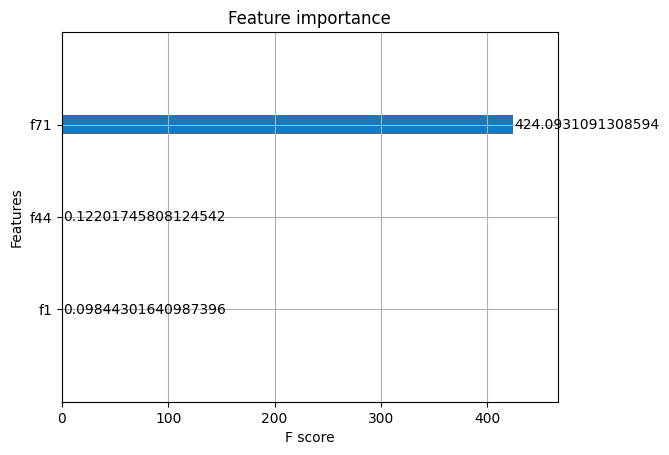

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import polars as pl
import numpy as np

print(test_df["active_flag"].value_counts())


# Step 4: Train the XGBoost Model
xgb_model = XGBClassifier(
    objective='binary:logistic', eval_metric='error',
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=True,
)

# Step 5: Predict on Test Set and Apply Custom Threshold
y_test_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # Predict probabilities
threshold = 0.7  # Custom threshold for flagging
y_test_custom = (y_test_pred_proba >= threshold).astype(int)

# Step 6: Evaluate the Model
print(f"Custom Threshold Accuracy: {accuracy_score(y_test, y_test_custom):.4f}")
print(f"Custom Threshold Classification Report:\n{classification_report(y_test, y_test_custom)}")

# Step 7: Save Predictions and Probabilities
test_df = test_df.with_columns(
    pl.Series(name="probability_reorder", values=y_test_pred_proba),
    pl.Series(name="flag_reorder", values=y_test_custom)
)
test_df.write_csv("test_with_predictions.csv")

# Step 8: Feature Importance (Optional)
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(xgb_model, max_num_features=10, importance_type="gain")
plt.show()

Train class distribution:
shape: (2, 2)
┌─────────────┬───────┐
│ active_flag ┆ count │
│ ---         ┆ ---   │
│ i32         ┆ u32   │
╞═════════════╪═══════╡
│ 0           ┆ 4067  │
│ 1           ┆ 1461  │
└─────────────┴───────┘
Validation class distribution:
shape: (2, 2)
┌─────────────┬───────┐
│ active_flag ┆ count │
│ ---         ┆ ---   │
│ i32         ┆ u32   │
╞═════════════╪═══════╡
│ 0           ┆ 1571  │
│ 1           ┆ 1242  │
└─────────────┴───────┘
Test class distribution:
shape: (2, 2)
┌─────────────┬───────┐
│ active_flag ┆ count │
│ ---         ┆ ---   │
│ i32         ┆ u32   │
╞═════════════╪═══════╡
│ 1           ┆ 391   │
│ 0           ┆ 1268  │
└─────────────┴───────┘
[0]	validation_0-error:0.26429	validation_1-error:0.44152
[1]	validation_0-error:0.26429	validation_1-error:0.44152
[2]	validation_0-error:0.26429	validation_1-error:0.44152
[3]	validation_0-error:0.00000	validation_1-error:0.00000
[4]	validation_0-error:0.00000	validation_1-error:0.00000
[5]	valida

p:\python\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:02:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-error:0.00000	validation_1-error:0.00000
[11]	validation_0-error:0.00000	validation_1-error:0.00000
[12]	validation_0-error:0.00000	validation_1-error:0.00000
[13]	validation_0-error:0.00000	validation_1-error:0.00000
[14]	validation_0-error:0.00000	validation_1-error:0.00000
[15]	validation_0-error:0.00000	validation_1-error:0.00000
[16]	validation_0-error:0.00000	validation_1-error:0.00000
[17]	validation_0-error:0.00000	validation_1-error:0.00000
[18]	validation_0-error:0.00000	validation_1-error:0.00000
[19]	validation_0-error:0.00000	validation_1-error:0.00000
[20]	validation_0-error:0.00000	validation_1-error:0.00000
[21]	validation_0-error:0.00000	validation_1-error:0.00000
[22]	validation_0-error:0.00000	validation_1-error:0.00000
[23]	validation_0-error:0.00000	validation_1-error:0.00000
[24]	validation_0-error:0.00000	validation_1-error:0.00000
[25]	validation_0-error:0.00000	validation_1-error:0.00000
[26]	validation_0-error:0.00000	validation_1-error:0.000

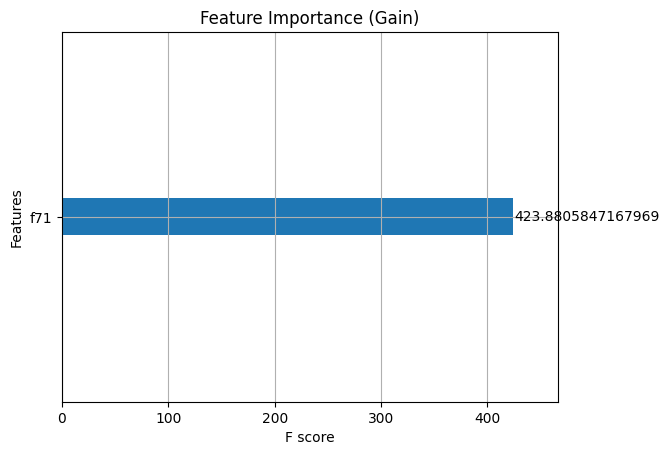

In [21]:
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, classification_report
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Feature Engineering
X = X.with_columns(
    pl.when(pl.col("Days Since Last Order") <= 180)
    .then(1)
    .otherwise(0)
    .alias("active_flag")
)

X = X.with_columns(
    pl.when(pl.col("Days Since Last Order") > 365)
    .then(1)
    .otherwise(0)
    .alias("inactive_flag")
)

df_features = X.drop(["active_flag", "inactive_flag", "Days Since Last Order"])
train_df = X.select(["cust_no", "active_flag"]).join(df_features, on="cust_no", how="inner")

# Step 2: Split Data into Train, Validation, and Test Sets
unique_customers = train_df["cust_no"].unique().to_numpy()  # Convert to NumPy for shuffling
np.random.seed(42)
np.random.shuffle(unique_customers)

num_customers = len(unique_customers)
train_size = int(0.7 * num_customers)
val_size = int(0.2 * num_customers)

train_customers = unique_customers[:train_size]
val_customers = unique_customers[train_size:train_size + val_size]
test_customers = unique_customers[train_size + val_size:]

train_customers_pl = pl.Series("cust_no", train_customers)
val_customers_pl = pl.Series("cust_no", val_customers)
test_customers_pl = pl.Series("cust_no", test_customers)

train_df = X.filter(X["cust_no"].is_in(train_customers_pl))
val_df = X.filter(X["cust_no"].is_in(val_customers_pl))
test_df = X.filter(X["cust_no"].is_in(test_customers_pl))

# Step 3: Define Features and Targets
target_col = "active_flag"
exclude_cols = ["cust_no", target_col, "inactive_flag",]
feature_cols = [col for col in train_df.columns if col not in exclude_cols]

X_train = train_df.select(feature_cols).to_numpy()
y_train = train_df[target_col].to_numpy()
X_val = val_df.select(feature_cols).to_numpy()
y_val = val_df[target_col].to_numpy()
X_test = test_df.select(feature_cols).to_numpy()
y_test = test_df[target_col].to_numpy()

print("Train class distribution:")
print(train_df[target_col].value_counts())

print("Validation class distribution:")
print(val_df[target_col].value_counts())

print("Test class distribution:")
print(test_df[target_col].value_counts())

# Step 4: Train the XGBoost Model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='error',
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    gamma=1,             # Minimum loss reduction for a split
    reg_alpha=0.1,       # L1 regularization
    reg_lambda=1 
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=True
)

# Step 5: Predict on Test Set
y_test_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
threshold = 0.7
y_test_custom = (y_test_pred_proba >= threshold).astype(int)

# Step 6: Evaluate the Model
print(f"Custom Threshold Accuracy: {accuracy_score(y_test, y_test_custom):.4f}")
print(f"Custom Threshold Classification Report:\n{classification_report(y_test, y_test_custom)}")

# Step 7: Save Predictions
test_df = test_df.with_columns(
    pl.Series(name="probability_reorder", values=y_test_pred_proba),
    pl.Series(name="flag_reorder", values=y_test_custom)
)
test_df.write_csv("test_with_predictions.csv")

# Step 8: Feature Importance
plot_importance(xgb_model, max_num_features=10, importance_type="gain")
plt.title("Feature Importance (Gain)")
plt.show()


In [22]:
import shap
import matplotlib.pyplot as plt
import shap
import matplotlib.pyplot as plt

# Initialize SHAP Explainer
explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values for training data
shap_values = explainer.shap_values(X_train)

# SHAP Summary Plot (Global Interpretation)
shap.summary_plot(shap_values, X_train, feature_names=feature_cols)


Features used in the model:
['orig_ord_type_cde', 'presc_no', 'orig_ord_line_id', 'Pharmacode', 'Product ID MES', 'Product Description', 'Product Availability', 'Product Dispension Type', 'Product Dispension Type Class', 'Product CatCode 1', 'Product CatCode 2', 'Product Generics Code', 'Product Basename', 'Product Company', 'Product ATC (EPHMRA)', 'Product Class PCG', 'Product Type', 'Product Segment', 'iqvia_stop', 'Main Supplier', 'pipeline_actual', 'pipeline_history', 'pipeline_start', 'pipeline_end', 'official Pharmacode', 'Product ATC (WHO)', 'ATC (WHO) level 1', 'ATC (WHO) level 2', 'ATC (WHO) level 3', 'ATC (WHO) level 4', 'ATC (WHO) level 5', 'Product Category Management', 'Category Management level 1', 'Category Management level 2', 'Category Management level 3', 'Category Management level 4', 'Category Management level 5', 'Product Therapeutic Index Code', 'Product Unit', 'Product Unit Container', 'pharm_no', 'nk_flg', 'nk_year', 'ord_type_cde', 'ord_no', 'shp_art_cnt', 'ord

In [18]:
# Feature names are derived from the feature_cols list
feature_names = feature_cols  # These are the column names used in the model

# Map the feature importance to the feature names
import pandas as pd
feature_importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the most important features
print(importance_df.head(10))


ImportError: C extension: pandas.compat not built. If you want to import pandas from the source directory, you may need to run 'python setup.py build_ext' to build the C extensions first.

In [86]:
train_df.shape #(10000, 592)

(10000, 592)

In [73]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Exclude target and ID columns
#exclude_cols = ["cust_no", "active_flag","inactive_flag", "Days Since Last Order"]
#feature_cols = [col for col in X.columns if col not in exclude_cols]
X_features = X2.select(X2.columns).to_numpy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

# Print explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained Variance Ratio for each component: {explained_variance_ratio}")
print(f"Total Explained Variance: {explained_variance_ratio.sum():.2f}")

# Convert PCA results back to Polars DataFrame
pca_columns = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca_df = pl.DataFrame(X_pca, schema=pca_columns)

# Add back non-feature columns (e.g., cust_no and target)
X_final = X.select(["cust_no", "active_flag"]).hstack(X_pca_df)
print(X_final.shape)
X_final.head(4)





Explained Variance Ratio for each component: [0.13714953 0.09206936 0.08506092 0.05421907 0.04573745 0.03797249
 0.0362435  0.03199498 0.02962359 0.02545495 0.02361305 0.02128869
 0.02029743 0.01869892 0.0182759  0.01662686 0.01623183 0.01565291
 0.01454211 0.01383576 0.01289227 0.01169919 0.01158931 0.01105801
 0.00992536 0.00921565 0.00895214 0.00868068 0.00814911 0.00782324
 0.00770394 0.00709519 0.00694442 0.00652918 0.00617229 0.0054537
 0.004835   0.00460575 0.00428129 0.00394519 0.0038765  0.00373721
 0.00359396 0.00342066 0.00333149 0.00316261 0.00289431 0.00278216
 0.0026358  0.00249011 0.00233827 0.0023203  0.00218158]
Total Explained Variance: 0.95
(10000, 55)


cust_no,active_flag,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53
i64,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
287437,0,-1.43602,-1.589691,-1.78686,-3.212381,3.84237,6.001762,-5.659061,23.690149,10.388566,1.228997,5.613391,3.982621,-2.17119,0.647333,-0.390241,1.316735,-1.300183,0.281368,-0.571693,-1.768325,-1.644961,1.203107,0.941683,-1.135323,-0.870379,-0.797318,-1.804472,-0.409627,-1.706981,0.883803,1.864252,-1.07362,-0.17681,0.638085,0.609961,-2.355189,4.656495,1.434042,1.335674,-2.067203,0.113894,-0.197121,0.043454,-0.673948,0.154166,1.560528,-0.540488,2.028188,0.075715,-1.243736,-1.12958,1.690305,0.465728
287437,0,-1.268405,-1.333969,-1.656486,-3.340364,3.819049,5.912385,-5.601357,23.823775,10.314646,1.496019,5.929416,4.084499,-2.558805,0.257104,-0.465559,1.445995,-1.242748,-0.010325,-0.6462,-1.930814,-1.594092,0.506245,0.643467,-0.767244,-0.323834,-0.911717,-1.179584,0.046864,-1.380697,1.850349,2.242791,-2.738519,-2.072336,1.260547,-0.904053,-0.529497,2.203349,1.749945,2.424062,-2.338492,-0.030483,0.264339,-0.036479,-0.039609,-0.506313,0.974312,-0.11482,2.220624,0.091371,-0.812226,-1.030789,0.257348,1.349925
287437,0,-1.520052,-1.521123,-1.883652,-3.360868,3.760723,5.842507,-5.504487,23.692754,10.261904,1.499719,5.899955,3.824449,-2.317185,0.744259,-0.354581,1.248576,-1.329631,0.332867,-0.375429,-1.821953,-1.895203,1.971705,1.284325,-1.394961,-1.359716,-1.281654,-2.293399,-0.560816,-1.966535,1.036348,2.172842,-0.544158,-0.622956,-0.136347,-0.504931,-1.875116,4.278032,0.519251,2.276482,-2.582959,0.030717,0.594653,0.073815,-0.489163,-0.161978,1.200249,0.071467,1.07726,-0.276021,-0.764548,-0.538745,0.390657,0.487068
287437,0,-1.706366,-1.287874,-1.702683,-3.599574,3.596363,5.163685,-5.029986,23.447445,10.204221,2.004419,6.731609,3.652709,-2.657548,0.254792,-0.735556,1.622917,-1.56382,0.278444,-0.447527,-1.482878,-2.92537,2.39448,1.324568,-2.052652,-0.863561,-2.426095,-2.645861,-0.128402,-2.797354,2.251465,2.890444,-1.068654,-2.69132,0.37683,-1.45561,0.275039,1.293599,0.474333,2.072924,-2.326338,-0.75266,0.048402,0.447157,0.555863,-0.32585,-0.148821,0.347087,0.828793,0.551378,0.193787,-1.693642,1.468377,0.541347


In [87]:
featrue_cols = X.columns
featrue_cols


['orig_ord_type_cde',
 'presc_no',
 'orig_ord_line_id',
 'Pharmacode',
 'Product ID MES',
 'Product Description',
 'Product Availability',
 'Product Dispension Type',
 'Product Dispension Type Class',
 'Product CatCode 1',
 'Product CatCode 2',
 'Product Generics Code',
 'Product Basename',
 'Product Company',
 'Product ATC (EPHMRA)',
 'Product Class PCG',
 'Product Type',
 'Product Segment',
 'iqvia_stop',
 'Main Supplier',
 'pipeline_actual',
 'pipeline_history',
 'pipeline_start',
 'pipeline_end',
 'official Pharmacode',
 'Product ATC (WHO)',
 'ATC (WHO) level 1',
 'ATC (WHO) level 2',
 'ATC (WHO) level 3',
 'ATC (WHO) level 4',
 'ATC (WHO) level 5',
 'Product Category Management',
 'Category Management level 1',
 'Category Management level 2',
 'Category Management level 3',
 'Category Management level 4',
 'Category Management level 5',
 'Product Therapeutic Index Code',
 'Product Unit',
 'Product Unit Container',
 'pharm_no',
 'nk_flg',
 'nk_year',
 'ord_type_cde',
 'cust_no',
 '

In [75]:
# Get the PCA components
components = pca.components_  # Shape: (n_components, n_original_features)

# Map PCA components to original features
feature_names = featrue_cols  # Original feature names
pca_feature_mapping = {
    f"PC{i+1}": sorted(
        zip(feature_names, components[i]),
        key=lambda x: abs(x[1]),  # Sort by absolute value of the contribution
        reverse=True
    )[:5]  # Top 5 contributing features for each PC
    for i in range(10)
}

# Print the mapping
for pc, contributions in pca_feature_mapping.items():
    print(f"{pc}:")
    for feature, weight in contributions:
        print(f"  {feature}: {weight:.4f}")




PC1:
  TherdaysAct_A10H: 0.1135
  TherdaysMix_A06A: 0.1134
  ActLength_G04E: 0.1134
  ActDSLO_A04A9: 0.1134
  TherdaysAct_N05B5: 0.1134
PC2:
  ActLength_N06C: 0.1362
  TherdaysMix_R02A: 0.1362
  ActLength_A03A: 0.1362
  ActLength_D07A: 0.1362
  ActLength_D10A: 0.1362
PC3:
  TherdaysMix_A12C1: 0.1396
  ActLength_A11E1: 0.1393
  TherdaysAct_A11E1: 0.1393
  ActDSLO_N02C: 0.1393
  ActLength_B01B: 0.1392
PC4:
  TherdaysSt_N06C: 0.1588
  TherdaysMix_N06C: 0.1588
  ActLength_R05C: 0.1582
  ActLength_N07C: 0.1582
  ActLength_R01A9: 0.1582
PC5:
  TherdaysSt_N06E: 0.1832
  ActLength_N06E: 0.1832
  ActLength_N03A: 0.1829
  TherdaysSt_H03A: 0.1829
  TherdaysMix_C09C: 0.1829
PC6:
  TherdaysSt_D02A: 0.1324
  TherdaysMix_D02A: 0.1324
  TherdaysSt_A06B: 0.1322
  ActLength_J01G: 0.1322
  TherdaysAct_D02A: 0.1322
PC7:
  TherdaysSt_N07B: 0.1381
  TherdaysMix_N07B: 0.1364
  TherdaysSt_A06B: 0.1331
  ActLength_J01G: 0.1331
  TherdaysAct_D02A: 0.1331
PC8:
  TherdaysAct_C10C: 0.1887
  ActDSLO_D04A: 0.1887
  

In [50]:
X.columns

['orig_ord_type_cde',
 'presc_no',
 'orig_ord_line_id',
 'Pharmacode',
 'Product ID MES',
 'Product Description',
 'Product Availability',
 'Product Dispension Type',
 'Product Dispension Type Class',
 'Product CatCode 1',
 'Product CatCode 2',
 'Product Generics Code',
 'Product Basename',
 'Product Company',
 'Product ATC (EPHMRA)',
 'Product Class PCG',
 'Product Type',
 'Product Segment',
 'iqvia_stop',
 'Main Supplier',
 'pipeline_actual',
 'pipeline_history',
 'pipeline_start',
 'pipeline_end',
 'official Pharmacode',
 'Product ATC (WHO)',
 'ATC (WHO) level 1',
 'ATC (WHO) level 2',
 'ATC (WHO) level 3',
 'ATC (WHO) level 4',
 'ATC (WHO) level 5',
 'Product Category Management',
 'Category Management level 1',
 'Category Management level 2',
 'Category Management level 3',
 'Category Management level 4',
 'Category Management level 5',
 'Product Therapeutic Index Code',
 'Product Unit',
 'Product Unit Container',
 'pharm_no',
 'nk_flg',
 'nk_year',
 'ord_type_cde',
 'cust_no',
 '

In [77]:
X

orig_ord_type_cde,presc_no,orig_ord_line_id,Pharmacode,Product ID MES,Product Description,Product Availability,Product Dispension Type,Product Dispension Type Class,Product CatCode 1,Product CatCode 2,Product Generics Code,Product Basename,Product Company,Product ATC (EPHMRA),Product Class PCG,Product Type,Product Segment,iqvia_stop,Main Supplier,pipeline_actual,pipeline_history,pipeline_start,pipeline_end,official Pharmacode,Product ATC (WHO),ATC (WHO) level 1,ATC (WHO) level 2,ATC (WHO) level 3,ATC (WHO) level 4,ATC (WHO) level 5,Product Category Management,Category Management level 1,Category Management level 2,Category Management level 3,Category Management level 4,Category Management level 5,…,ActDSLO_A11C,ActDSLO_B01F,ActDSLO_L02B,ActDSLO_N02A,ActDSLO_R01A9,ActDSLO_D08A,ActDSLO_D07B,ActDSLO_L01B,ActDSLO_C04A,ActDSLO_G04E,ActDSLO_A04A9,ActDSLO_A06A,ActDSLO_C01C,ActDSLO_D06D,ActDSLO_G03C,ActDSLO_G04A,ActDSLO_G04D,ActDSLO_J05B,ActDSLO_M03B,ActDSLO_N02B2,ActDSLO_N02C,ActDSLO_R01A7,ActDSLO_A07B,ActDSLO_A10N,ActDSLO_B03A2,ActDSLO_C10C,ActDSLO_N07E,ART_BASENAME,ART_FULLNAME,ART_FORM,CONCT,MolText,MONO COMBI,prev_pharm_no,prev_product_atc,days_since_prev,dominant_refill_trend
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f32
1,15030054,1000,2688963,126358,769,0,2,1,0,400,4,369,136,115,27,0,13,0,6,0,0,0,0,2688963,281,12,39,39,121,140,4,2,24,28,28,28,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,380,768,135,52,158,1,0,219,0,34596.0
1,15091126,4000,1390813,19903,2012,0,2,1,0,400,5,997,151,155,23,0,13,0,7,0,0,0,0,1390813,370,7,22,128,150,149,8,2,14,15,15,15,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1020,2011,20,187,166,1,2688963,115,44,34596.0
1,14511031,1000,1427060,21191,473,0,2,1,0,402,4,219,118,162,27,0,13,0,7,0,0,0,0,1427060,385,7,22,128,58,107,8,2,14,15,15,15,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,226,471,116,224,112,1,1390813,155,0,34596.0
1,15091126,2000,1799063,44094,1138,0,2,1,0,400,4,553,57,53,27,0,11,0,7,0,0,0,0,1799063,97,0,47,14,198,321,0,2,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,568,1134,42,56,353,1,1427060,162,0,34596.0
1,14511031,1000,1427060,21191,473,0,2,1,0,402,4,219,118,162,27,0,13,0,7,0,0,0,0,1427060,385,7,22,128,58,107,8,2,14,15,15,15,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,226,471,116,224,112,1,1799063,53,56,34596.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1,20290965,2000,2210291,78074,305,1,2,2,0,400,4,131,79,51,27,0,11,0,9,0,0,0,0,2210291,92,0,47,64,116,84,28,1,26,33,33,33,…,494,0,0,0,0,0,6509,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,303,58,193,80,0,1427060,162,0,100359.0
1,20290965,2000,2210291,78074,305,1,2,2,0,400,4,131,79,51,27,0,11,0,9,0,0,0,0,2210291,92,0,47,64,116,84,28,1,26,33,33,33,…,494,0,0,0,0,0,6509,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,303,58,193,141,0,2210291,51,0,100359.0
1,20290965,6000,4461407,301717,134,0,2,1,0,402,4,60,44,57,27,0,9,0,7,0,0,0,0,4461407,108,4,25,49,279,6,1,2,6,6,6,6,…,494,0,0,0,0,0,6509,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,67,134,116,71,7,1,2210291,51,0,100359.0


In [76]:
# Use only the top 7 PCs
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
#import shap
unique_customers = X['cust_no'].unique()
np.random.seed(42) 
np.random.shuffle(unique_customers)


num_customers = len(unique_customers) # 1000 customers
train_size = int(0.7 * num_customers) # 70% training
val_size = int(0.2 * num_customers) # 20% validation

train_customers = unique_customers[:train_size]
val_customers = unique_customers[train_size:train_size + val_size]
test_customers = unique_customers[train_size + val_size:]
train_customers_pl = pl.Series("cust_no", train_customers)
val_customers_pl = pl.Series("cust_no", val_customers)
test_customers_pl = pl.Series("cust_no", test_customers)



# Train XGBoost
xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

xgb_model.fit(
    X_train_pca, y_train,
    eval_set=[(X_train_pca, y_train), (X_val_pca, y_val)],
    early_stopping_rounds=10,
    verbose=True
)

# Evaluate on test set
y_test_pred = xgb_model.predict(X_test_pca)
y_test_pred_proba = xgb_model.predict_proba(X_test_pca)[:, 1] # Predict probabilities on the test set
# Set threshold for flagging reorders
threshold = 0.7  # 70%
y_test_custom = (y_test_pred_proba >= threshold).astype(int)

# Evaluate the custom predictions
print(f"Custom Threshold Accuracy: {accuracy_score(y_test, y_test_custom):.4f}")
print(f"Custom Threshold Classification Report:\n{classification_report(y_test, y_test_custom)}")

#print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
#print(f"Classification Report:\n{classification_report(y_test, y_test_pred)}")

# Add probabilities and flags to the test DataFrame
test_df = test_df.with_columns(
    pl.Series(name="probability_reorder", values=y_test_pred_proba),
    pl.Series(name="flag_reorder", values=y_test_custom)
)
print(test_df.select(["cust_no", "probability_reorder", "flag_reorder"]).head(10))

# SHAP Explainability
#explainer = shap.Explainer(xgb_model, X_test_pca)
#shap_values = explainer(X_test_pca)

# SHAP Summary Plot for PCs

#shap.summary_plot(shap_values, X_test_pca, feature_names=[f"PC{i+1}" for i in range(10)])

# Map PC importance back to original features
#for i, pc_name in enumerate([f"PC{i+1}" for i in range(10)]):
#    print(f"\n{pc_name} contributions:")
#    for feature, weight in pca_feature_mapping[pc_name]:
#        print(f"  {feature}: {weight:.4f}")


C:\Users\FahRe\AppData\Local\Temp\ipykernel_14128\1169965842.py:7: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(unique_customers)


ColumnNotFoundError: PC1

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'select' <---
DF ["orig_ord_type_cde", "presc_no", "orig_ord_line_id", "galfrm_day"]; PROJECT */2062 COLUMNS; SELECTION: None

### Updated Approach to Use Validation Set During Optimization

In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
import numpy as np

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

best_auc = -np.inf
best_params = None
best_model = None

# Perform manual grid search
for params in ParameterGrid(param_grid):
    # Initialize model with current parameters
    xgb_model = XGBClassifier(
        objective="binary:logistic",
        use_label_encoder=False,
        eval_metric="auc",
        **params
    )
    
    # Fit model with early stopping using validation set
    xgb_model.fit(
        X_train_pca, y_train,
        eval_set=[(X_train_pca, y_train), (X_val_pca, y_val)],
        early_stopping_rounds=10,
        verbose=False
    )
    
    # Evaluate on validation set
    y_val_pred_proba = xgb_model.predict_proba(X_val_pca)[:, 1]
    val_auc = roc_auc_score(y_val, y_val_pred_proba)
    
    # Track the best model
    if val_auc > best_auc:
        best_auc = val_auc
        best_params = params
        best_model = xgb_model

# Evaluate the best model on the test set
y_test_pred = best_model.predict(X_test_pca)
y_test_pred_proba = best_model.predict_proba(X_test_pca)[:, 1]

print(f"Best parameters: {best_params}")
print(f"Best Validation AUC: {best_auc:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test AUC: {roc_auc_score(y_test, y_test_pred_proba):.4f}")
print(f"Classification Report (Test):\n{classification_report(y_test, y_test_pred)}")

# SHAP Explainability for the best model
explainer = shap.Explainer(best_model, X_test_pca)
shap_values = explainer(X_test_pca)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_pca, feature_names=[f"PC{i+1}" for i in range(7)])


## Split Data 
- Cust no random shuffle and split 70 procent trianing 20 procent validation and 20 test set


In [ ]:
import numpy as np
X

unique_customers = X['cust_no'].unique()
np.random.seed(42) 
np.random.shuffle(unique_customers)

num_customers = len(unique_customers) # 1000 customers
train_size = int(0.7 * num_customers) # 70% training
val_size = int(0.2 * num_customers) # 20% validation

train_customers = unique_customers[:train_size]
val_customers = unique_customers[train_size:train_size + val_size]
test_customers = unique_customers[train_size + val_size:]
train_customers_pl = pl.Series("cust_no", train_customers)
val_customers_pl = pl.Series("cust_no", val_customers)
test_customers_pl = pl.Series("cust_no", test_customers)

train_df = df.filter(df["cust_no"].is_in(train_customers_pl))
val_df = df.filter(df["cust_no"].is_in(val_customers_pl))
test_df = df.filter(df["cust_no"].is_in(test_customers_pl))
train_df.write_csv("train_data.csv")
val_df.write_csv("val_data.csv")
test_df.write_csv("test_data.csv")
print(f"Training set: {train_df.shape[0]} rows")
print(f"Validation set: {val_df.shape[0]} rows")
print(f"Test set: {test_df.shape[0]} rows")

# print numer of unique customers in each set
print(f"Training set: {train_df['cust_no'].n_unique()} customers")
print(f"Validation set: {val_df['cust_no'].n_unique()} customers")
print(f"Test set: {test_df['cust_no'].n_unique()} customers")

C:\Users\FahRe\AppData\Local\Temp\ipykernel_26492\2423124661.py:6: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(unique_customers)


Training set: 33119 rows
Validation set: 10175 rows
Test set: 6658 rows
Training set: 214 customers
Validation set: 61 customers
Test set: 31 customers


## Model


In [ ]:
import polars as pl
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import shap  # Explainability library

# Load the prepared datasets
train_df = pl.read_csv("train_data.csv")
val_df = pl.read_csv("val_data.csv")
test_df = pl.read_csv("test_data.csv")

# Define target column and feature columns
target_col = "adherence_risk_score"  # Replace with your actual target column
exclude_cols = ["cust_no", target_col]  # Exclude non-feature columns
feature_cols = [col for col in train_df.columns if col not in exclude_cols]

# Prepare the data
X_train = train_df.select(feature_cols).to_numpy()
y_train = train_df[target_col].to_numpy()

X_val = val_df.select(feature_cols).to_numpy()
y_val = val_df[target_col].to_numpy()

X_test = test_df.select(feature_cols).to_numpy()
y_test = test_df[target_col].to_numpy()

# Define the parameter grid for XGBoost
param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 6, 9],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# Set up the XGBoost classifier
xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit the model using the training data
grid_search.fit(X_train, y_train)

# Best parameters and score
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(f"Best Parameters: {best_params}")
print(f"Best CV AUC Score: {grid_search.best_score_:.4f}")

# Evaluate on the validation set
y_val_pred = best_model.predict(X_val)
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]
print("Validation Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(classification_report(y_val, y_val_pred))

# Evaluate on the test set
y_test_pred = best_model.predict(X_test)
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
print("Test Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(classification_report(y_test, y_test_pred))

# Add predictions and probabilities to test_df
test_df = test_df.with_columns(
    pl.Series(name="predictions", values=y_test_pred),
    pl.Series(name="probabilities", values=y_test_pred_proba)
)
test_df.write_csv("test_with_predictions.csv")

# SHAP Explainability
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test, feature_names=feature_cols)

# SHAP Dependence Plot (example for one feature)
shap.dependence_plot(0, shap_values.values, X_test, feature_names=feature_cols)
